In [1]:
'''
Notebook to debug figure plots, e.g. sampling from memory
'''

import os

import cmws
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from cmws import util
from cmws.examples.scene_understanding import data, render, run
from cmws.examples.scene_understanding import util as scene3d_util 
import seaborn as sns
import numpy as np
from cmws.examples.scene_understanding.plot import *


def importance_sample_memory(
    num_particles, obs, obs_id, generative_model, guide, memory, img_size=256
):
    # modifed from: https://github.com/tuananhle7/continuous_mws/blob/a43dd325e1e2c765d9811773ff5885b6f5f400e4/cmws/examples/timeseries/inference.py#L239
    """
    Args
        num_particles
        num_svi_iterations
        obs [batch_size, num_timesteps]
        obs_id [batch_size]
        generative_model
        guide
        memory
    Returns
        latent
            raw_expression [memory_size, batch_size, max_num_chars]
            eos [memory_size, batch_size, max_num_chars]
            raw_gp_params [memory_size, batch_size, max_num_chars, gp_params_dim]
        log_marginal_joint [memory_size, batch_size]
    """
    # Extract
    batch_size = obs.shape[0]
    memory_size = memory.size
    
    print("sampling discrete")

    # Sample discrete latent
    # [memory_size, batch_size, ...]
    discrete_latent = memory.select(obs_id)
    
    print("computing scores")

    # COMPUTE SCORES s_i = log p(d_i, x) for i  {1, ..., M}
    # [memory_size, batch_size]
    log_marginal_joint = cmws.losses.get_log_marginal_joint(
        generative_model, guide, discrete_latent, obs, num_particles
    )
    
    print("expanding and getting continuous")

    # Sample svi-optimized q(z_c | z_d, x)
    # -- Expand obs
    # [memory_size, batch_size, 3, img_size, img_size]
    obs_expanded = obs[None].expand([memory_size, batch_size, 3, img_size, img_size])
    # -- SVI
    continuous_latent = guide.sample_continuous(obs_expanded, discrete_latent)

    # Combine latents
    latent = discrete_latent[0], discrete_latent[1], continuous_latent

    return latent, log_marginal_joint


In [2]:
experiment_name = "cmws_vs_rws_learnColor"
device = "cpu"
save_dir = f"../save/{experiment_name}"
checkpoint_paths = []
for config_name in sorted(os.listdir(save_dir)):
    checkpoint_paths.append(util.get_checkpoint_path(experiment_name, config_name, -1))
checkpoint_path = 'save/cmws_vs_rws_learnColor/cmws_4_2_0.01_2/checkpoints/latest.pt'#checkpoint_paths[0]
checkpoint_path = f"../{checkpoint_path}"
model, optimizer, stats, run_args = scene3d_util.load_checkpoint(
                            checkpoint_path, device="cpu"
                        )
generative_model, guide = model["generative_model"], model["guide"]
num_iterations = len(stats.losses) # note: can use to filter out jobs!
save_dir = util.get_save_dir(run_args.experiment_name, run.get_config_name(run_args))

# Plot stats
plot_stats(f"{save_dir}/stats.png", stats)

# Plot reconstructions and other things
# Test data
# NOTE: Plotting the train dataset only
train_dataset = data.SceneUnderstandingDataset(
    device, run_args.num_grid_rows, run_args.num_grid_cols, test=False,
    remove_color=(run_args.remove_color == 1),
    mode=run_args.mode
)
obs, obs_id = train_dataset[:10]


color status:  False
path:  /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/1_1/cube_0.01/train.pt
23:37:12 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:348 | INFO: Loading dataset (test = False)...
23:37:12 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:352 | INFO: Dataset (test = False) loaded /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/1_1/cube_0.01/train.pt
23:37:12 | /om/user/katiemc/continuous_mws/cmws/memory.py:20 | INFO: Initializing memory


100%|██████████| 100/100 [00:00<00:00, 982.87it/s]


23:37:13 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to save/cmws_vs_rws_learnColor/cmws_4_2_0.01_2/stats.png
color status:  False
path:  /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/2_2/cube_0.01/train.pt
23:37:13 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:348 | INFO: Loading dataset (test = False)...
23:37:13 | /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data.py:352 | INFO: Dataset (test = False) loaded /om/user/katiemc/continuous_mws/cmws/examples/scene_understanding/data/2_2/cube_0.01/train.pt


In [3]:
memory = model["memory"]

In [4]:
obs = obs.squeeze(1)
num_test_obs, num_channels, im_size, _ = obs.shape
im_size = 128
num_samples = 1

num_particles = memory.size
latent, log_weight = importance_sample_memory(
    num_particles, obs, obs_id, generative_model, guide, memory, im_size
)

num_blocks, stacking_program, raw_locations = latent

# Sort by log weight
# [num_test_obs, num_particles], [num_test_obs, num_particles]
_, sorted_indices = torch.sort(log_weight.T, descending=True)

# Sample predictions
# -- Expand obs
obs_expanded = obs[None].expand(num_particles, num_test_obs, 3, im_size, im_size)

sampling discrete
computing scores
raw locations OBS:  torch.Size([5, 5, 10, 2, 2, 3])
SIZES:  torch.Size([250, 4, 3])
expanding and getting continuous


In [5]:
# # -- Sample predictions
# obs_predictions = generative_model.sample_obs_predictions(latent, obs_expanded, [num_samples])
# predictive_dist = generative_model.get_predictive_dist(latent, obs_expanded)
# predictive_mean = predictive_dist.loc
# predictive_std = predictive_dist.covariance_matrix.diagonal(dim1=-2, dim2=-1).sqrt()
# predictive_low = predictive_mean - 2 * predictive_std
# predictive_high = predictive_mean + 2 * predictive_std

In [6]:
test_obs_id = 8
particle_id = 4 

sorted_particle_id = sorted_indices[test_obs_id, particle_id]


In [7]:
num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

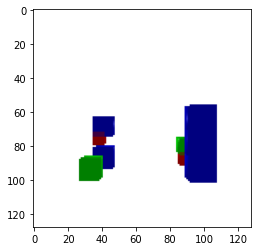

In [8]:
img = obs_expanded[0][test_obs_id].permute(1,2,0)
plt.imshow(img)

In [9]:
obs_expanded.shape

torch.Size([5, 10, 3, 128, 128])

In [10]:
sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)
sampled_obs = generative_model.get_obs_loc(sampled_latent)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])


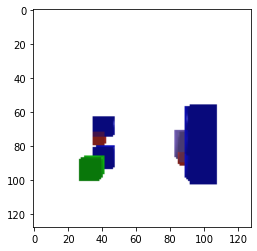

In [11]:
img = sampled_obs.permute(1,2,0).detach().numpy()
plt.imshow(img)

In [12]:
obs_expanded.shape

torch.Size([5, 10, 3, 128, 128])

In [13]:
log_weight.T

tensor([[-45282.5391, -45274.8594, -45267.8789, -45226.4375, -45186.2148],
        [-45248.0195, -45242.9102, -45240.2031, -45225.9805, -45207.3398],
        [-45254.2305, -45253.1992, -45258.4922, -45247.9414, -45196.4492],
        [-45275.6250, -45264.5547, -45259.4492, -45253.2617, -45210.2070],
        [-45319.5273, -45307.2305, -45308.7969, -45284.0703, -45271.2500],
        [-45254.2656, -45252.7812, -45254.2617, -45236.0000, -45228.0195],
        [-45278.0078, -45288.3438, -45272.6055, -45270.9570, -45218.9648],
        [-45268.9609, -45261.8594, -45252.3438, -45238.4258, -45234.2734],
        [-45250.4023, -45247.6797, -45239.2891, -45239.5859, -45212.2188],
        [-45243.9727, -45238.0547, -45224.7422, -45207.0469, -45206.9336]],
       grad_fn=<PermuteBackward>)

In [14]:
log_weight.T[0][0].item() < log_weight.T[0][1].item()

True

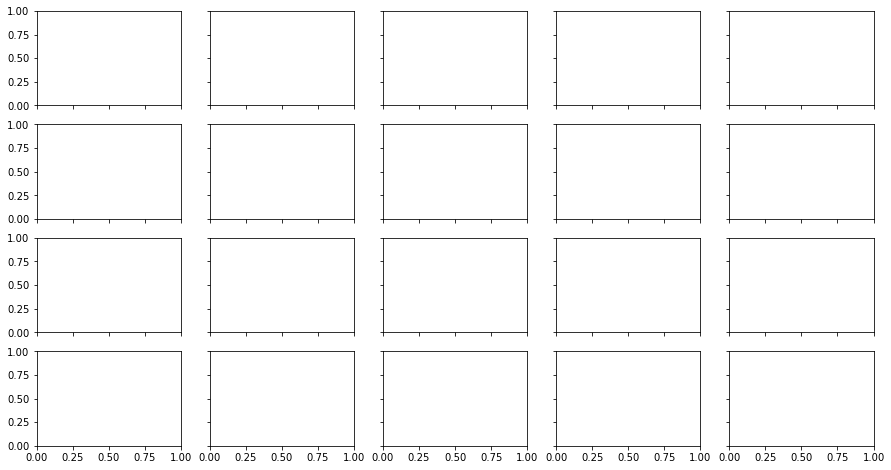

In [15]:
num_rows = 4
num_cols = 5 # number to show
fig, axss = plt.subplots(
    num_rows,
    num_cols,
    figsize=(3 * num_cols, 2 * num_rows),
    sharex=True,
    sharey=True,
    squeeze=False,
)

In [16]:
for row in range(num_rows): 
    for test_obs_id in range(num_cols): 
        ax = axss[row][test_obs_id]
        if row == 0: # pull from observations 
            img = obs_expanded[0][test_obs_id].permute(1,2,0)
        else: 
            particle_id = row - 1
            sorted_particle_id = sorted_indices[test_obs_id, particle_id]
            
            num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
            stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
            raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]
            
            sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)
            
            camera_elevation = 30
            camera_azimuth = -40 # 40
            
            sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))
            
            img = sampled_obs.permute(1,2,0).detach().numpy()
            ax.text(
                0.95,
                0.95,
                f"{log_weight[sorted_particle_id, test_obs_id].item():.0f}",
                transform=ax.transAxes,
                fontsize=7,
                va="top",
                ha="right",
                color="black",
            )
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

path = "sample_memory.png"
util.save_fig(fig, path)

raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1,

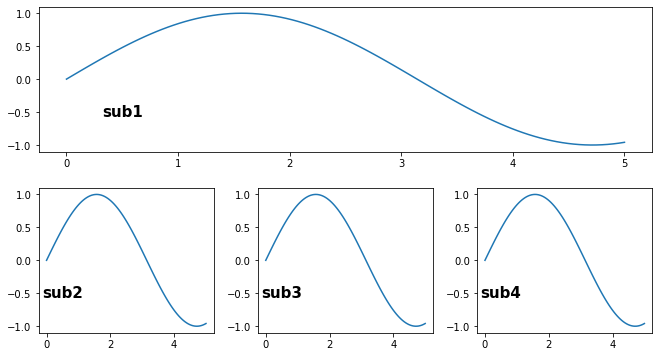

In [18]:
fig = plt.figure(figsize=(11, 6))

x = np.linspace(0., 5., 100)
y = np.sin(x)

rows = 2
columns = 3

x = np.linspace(0., 5., 100)
y = np.sin(x)

grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

plt.subplot(grid[0, :])
plt.annotate('sub1', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
plt.plot(x, y)

plt.subplot(grid[1, 0])
plt.annotate('sub2', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
plt.plot(x, y)

plt.subplot(grid[1, 1])
plt.annotate('sub3', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
plt.plot(x, y)

plt.subplot(grid[1, 2])
plt.annotate('sub4', xy = (0.5, -0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)
plt.plot(x, y)

In [ ]:
import matplotlib.gridspec as gridspec
text_width = 6.75
column_width = 6.5 / 2.
text_height = 9.
golden = (1 + 5 ** 0.5) / 2 # golden ratio

rows = 4
cols = 3#5

# for the samples from memory
views = [-40, 40] # azimuths
num_views = len(views)
num_samples = 3 

num_primitives = generative_model.num_primitives

# gridspec inside gridspec
f = plt.figure(figsize=(12,6), dpi=600)
# f = plt.figure(figsize=(text_width, rows/cols * text_width), dpi=600)
gs0 = gridspec.GridSpec(rows, cols, figure=f)

high_res_img = 256

generative_model.im_size = high_res_img#512 # change for higher res

for x in range(rows):
    if x >= 2: 
        if x == 3: # show primitives
            # 1 row, num primitives = num cols
            print("in grid spec")
            gs00 = gridspec.GridSpecFromSubplotSpec(1, num_primitives, subplot_spec=gs0[x, 0:],
                                               wspace=0.025, hspace=0)
            # Init
            location = torch.tensor([0, 0, -1], device=device).float()
            for i in range(num_primitives): 
                print("primitive: ", i)
                ax = f.add_subplot(gs00[0, i])
                obs = render.render_block(
                    generative_model.primitives[i].size,
                    generative_model.primitives[i].color,
                    location,
                    im_size=high_res_img,
                    remove_color=False,
                    mode="cube",
#                     camera_elevation=30,
#                     camera_azimuth=40
                )
                ax.imshow(obs.detach().numpy())
                print("created image: ", obs.shape)
                ax.set_xticks([])
                ax.set_yticks([])
                if i == 0: # middle entry
                    ax.set_ylabel(f'Primitives', fontsize=10, fontfamily='serif')
            continue # skip the inner loop of cols 
        else: continue 
    for y in range(cols):
        test_obs_id = y 
        if x == 0: # observations 
            ax = f.add_subplot(gs0[x, y])
            img = obs_expanded[0][test_obs_id].permute(1,2,0)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
            if y == 0: # middle entry
                ax.set_ylabel(f'Observations', fontsize=10, fontfamily='serif')
        else: 
            gs00 = gridspec.GridSpecFromSubplotSpec(num_samples, num_views, subplot_spec=gs0[x:-1, y],
                                               wspace=0.025, hspace=0)
            for xx in range(num_samples): 
                for yy in range(num_views): 
                    print("yy: ", yy)
                    ax = f.add_subplot(gs00[xx, yy])
                    
                    particle_id = xx
                    sorted_particle_id = sorted_indices[test_obs_id, particle_id]

                    num_blocks_selected = num_blocks[sorted_particle_id, test_obs_id]
                    stacking_program_selected = stacking_program[sorted_particle_id, test_obs_id]
                    raw_locations_selected = raw_locations[sorted_particle_id, test_obs_id]

                    sampled_latent = (num_blocks_selected, stacking_program_selected, raw_locations_selected)

                    camera_elevation = 30
                    camera_azimuth = views[yy]

                    sampled_obs = generative_model.get_obs_loc(sampled_latent, (camera_elevation, camera_azimuth))

                    img = sampled_obs.permute(1,2,0).detach().numpy()
#                     ax.text(
#                         0.95,
#                         0.95,
#                         f"{log_weight[sorted_particle_id, test_obs_id].item():.0f}",
#                         transform=ax.transAxes,
#                         fontsize=7,
#                         va="top",
#                         ha="right",
#                         color="black",
#                     )
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                if y == 0 and yy == 0 and xx == 1: # middle entry
                    ax.set_ylabel(f'Posterior Samples', fontsize=10, fontfamily='serif')

path = "sample_memory.pdf"
util.save_fig(f, path, dpi=200)



yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  0
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])
yy:  1
raw locations OBS:  torch.Size([2, 2, 3])
SIZES:  torch.Size([1, 4, 3])


In [24]:
util.save_fig(f, path)

23:55:41 | /om/user/katiemc/continuous_mws/cmws/util.py:293 | INFO: Saved to sample_memory2.png


In [40]:
num_primitives

5